## Model setup XBeach 2D

Setup a 2D XBeach model with the Python toolbox

In [74]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 
from matplotlib import cm
import os
import sys

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Import the toolbox and set the xbeach styleshoot for plotting

In [75]:
## import xbeach tools
sys.path.append(os.path.abspath(os.path.join('lib', 'xbeach-toolbox', 'scripts')))

from xbeachtools import xgrid, ygrid, seaward_extend, XBeachModelSetup, offshore_depth, lateral_extend
plt.style.use(os.path.join('lib', 'xbeach-toolbox', 'scripts', 'xb.mplstyle'))

### Data
Load and plot the bathymetry data

(1476, 656)


Text(0.5, 0.5, 'y [m]')

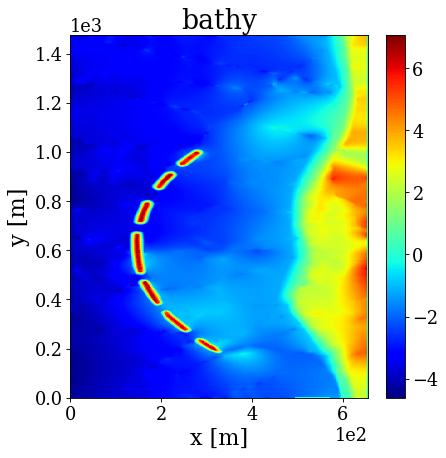

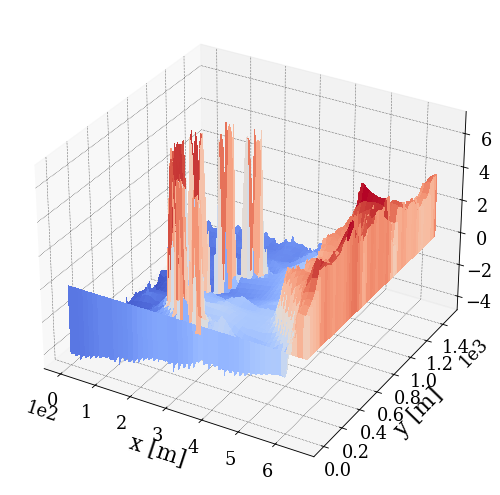

In [105]:
## load data
# bathy = np.loadtxt('./lib/xbeach-toolbox/examples/clean/bathy.dep')
bathy = np.loadtxt('./lib/DEM-to-grid/output/bathy.dep')
print(bathy.shape)

## set bathy grid
nx = 656
ny = 1476
dx = 1
dy = 1

x = np.linspace(0,(nx-1)*dx,nx)
y = np.linspace(0,(ny-1)*dy,ny)

X, Y = np.meshgrid(x,y)

## plot
plt.figure()
plt.pcolor(x,y,bathy)
plt.colorbar()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('bathy')

fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_surface(X, Y, bathy, cmap=cm.coolwarm,  linewidth=0, antialiased=False)
plt.xlabel('x [m]')
plt.ylabel('y [m]')

### Create x-grid
Create spatially varying x-grid resolution.

Text(0, 0.5, 'z [m]')

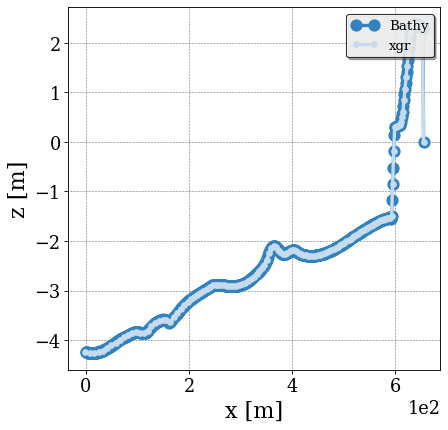

In [106]:
xgr,zgr = xgrid(x, bathy[20,:],dxmin=2)


plt.figure()
plt.plot(x,bathy[20,:],'-o')
plt.plot(xgr,zgr,'.-')
plt.legend(['Bathy','xgr'])
plt.xlabel('x [m]')
plt.ylabel('z [m]')

### Create y-grid

Create spatially varying y-grid resolution.

Enable optimization of transition distance
Area type center
Transition 147.5


Text(0, 0.5, 'dy [m]')

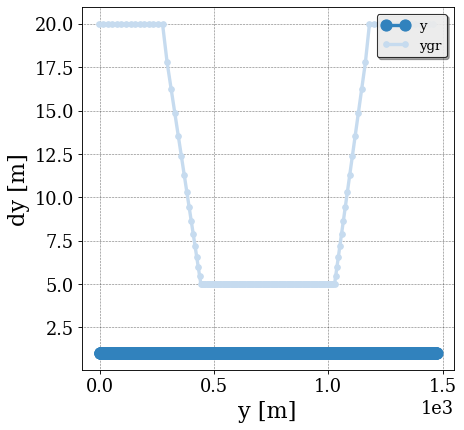

In [107]:
ygr = ygrid(y)

plt.figure()
plt.plot(y[:-1],np.diff(y),'-o')
plt.plot(ygr[:-1],np.diff(ygr),'.-')
plt.legend(['y','ygr'])
plt.xlabel('y [m]')
plt.ylabel('dy [m]')

### Interpolate
Interpolate data to new grid

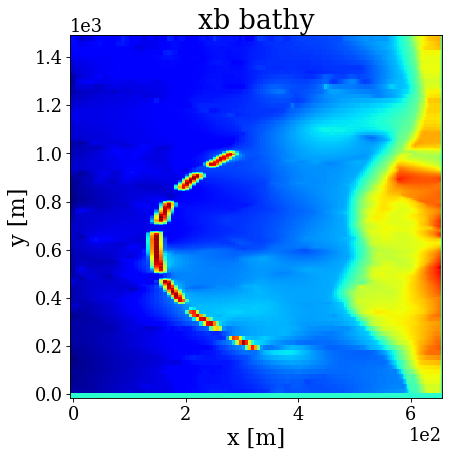

In [108]:
f = interpolate.interp2d(x, y, bathy, kind='linear')

zgr = f(xgr,ygr)

plt.figure()
plt.pcolor(xgr,ygr,zgr)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('xb bathy')

xgr, ygr = np.meshgrid(xgr,ygr)

### Seaward extend
Extend the grid to the required offshore depth. In this case 20 m with a artificial slope of 1/20.

In [110]:
d_start, slope, Hm0_shoal = offshore_depth(Hm0=9, Tp=15, depth_offshore_profile=abs(bathy[0,0]), depth_boundary_conditions=20)

xgr, ygr, zgr = seaward_extend(xgr,ygr,zgr,slope=1/20,depth=-20)

plt.figure()
plt.pcolor(xgr,ygr,zgr)

plt.figure()
plt.plot(xgr[:,:].T,zgr[:,:].T)
plt.xlabel('x [m]')
plt.ylabel('z [m]')


Artificial slope of 1:10
Hm0,shoal = nan
d start = 0.0
Hm0,shoal/d profile = nan
Hm0,shoal/d slope = nan
n profile = nan


UnboundLocalError: local variable 'n_startdepth' referenced before assignment

### Lateral extend

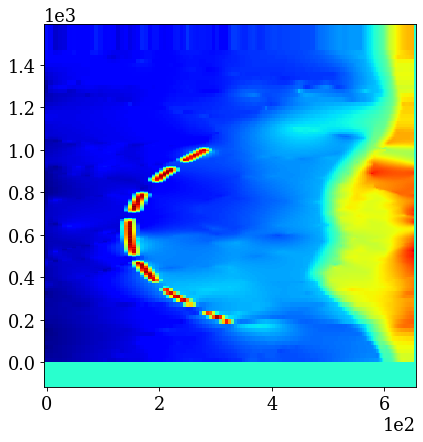

In [111]:
xgr,ygr,zgr = lateral_extend(xgr,ygr,zgr,n=5)

plt.figure()
plt.pcolor(xgr,ygr,zgr)

### Create model setup
Create the model setup class

In [112]:
xb_setup = XBeachModelSetup('Northbay')

print(xb_setup)

Northbay


Add the grid, wave boundary conditions and parameter to the model

In [113]:
xb_setup.set_grid(xgr,ygr,zgr)

xb_setup.set_waves('jonstable',{'Hm0':[1.5, 2, 1.5],'Tp':[4, 5, 4],'gammajsp':[3.3, 3.3, 3.3], 's' : [20,20,20], 'mainang':[270,280, 290],'duration':[3600, 3600, 3600],'dtbc':[1,1,1]})

xb_setup.set_params({'Wavemodel':'surfbeat',
                     'morphology':0,
                     'befriccoef':0.01,
                     'tstop':3600,
                     'nglobalvar':['zb','zs','H'],
                     'nmeanvar':['zb'],
                     'npoints':['1 0', '6 0', '10 0', '12 0']})

Write the model setup

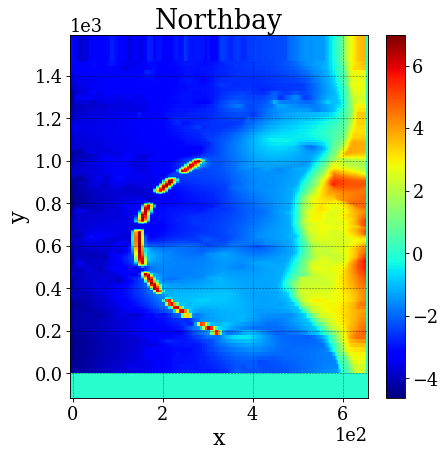

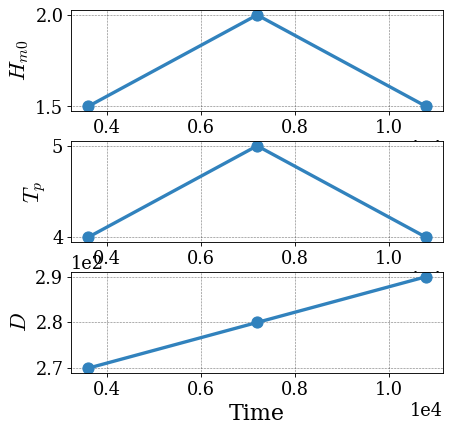

In [114]:
sim_path = os.path.join('output-2D')
if not os.path.exists(sim_path):
    os.mkdir(sim_path)
xb_setup.write_model(os.path.join(sim_path))